# Exploring a canopy RT model: PROSAIL
## J Gómez-Dans (UCL & NCEO)


### This implementation of PROSAIL

There are quite a few different versions of the SAIL model. This is probably the second simplest, as it assumes a single canopy layer, with a simple hotspot correction. The soil boundary is assumed to be Lambertian, and a combination of two soil spectra (typically one wet and one dry). Leaf optical properties are calculated with **PROSPECT 5B** (which you should already be familiar with). In total, we have 11 input parameters (as well as the illumination/acquisition geometry, controlled by the solar zenith angle, the view zenith angle and the relative azimuth angle). The input parameters are

* $N$ (leaf layers)
* $Cab$ (chlorophyll ab conc)
* $Car$ (carotenoid conc)
* $Cbrown$ (senescent pigment
* $Cw$ (equivalent leaf water)
* $Cm$ (dry matter conc)
* LAI (leaf area index)
* LIDF (the mean leaf angle)
* RSOIL (soil brightness term)
* PSOIL (soil moisture factor: 0 wet, 1 dry)
* HOTSPOT (the value of the hotspot parameter, typically the ratio of leave size to canopy height)

The soil is assumed Lambertian, and made up of the linear combination of two spectra, $\rho_{s}^{d}$ and $\rho_{s}^{w}$, dry and wet, respectively. The soil spectrum is calculated as

$$
\rho_{s}=R\cdot\left(P\cdot\rho_{s}^{d} + \left(1-P\right)\cdot \rho_{s}^{w}\right).
$$

This version of PROSAIL uses a Campbell leaf angle distribution function. Rather than choosing discrete distributions, the Campbell function parameterises the LAD function with a single parameter, the mean leaf angle.

### Sensitivity analysis

The aim of this exercise is to look at the sensitivity of PROSAIL to different parametes spectrally, in a way that is similar to what you did before with PROSPECT. Remember that this experiment is still a local sensitivity analysis experiment around $\mathbf{x_0}$, so make sure you consider different locations in parameter space. Also consider the effect of acquisition geometry.

You can use the function **``prosail_sensitivity_ssa``**, from ``prosail_functions``. Remember that this function has extensive help on its syntax.

* Where do parameters show the most/the least sensitivity spectrally?
* Where do these sensitivities change with acquisition geometry?



In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prosail_functions import *
plot_config()
import prosail

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:857: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(650, 890)

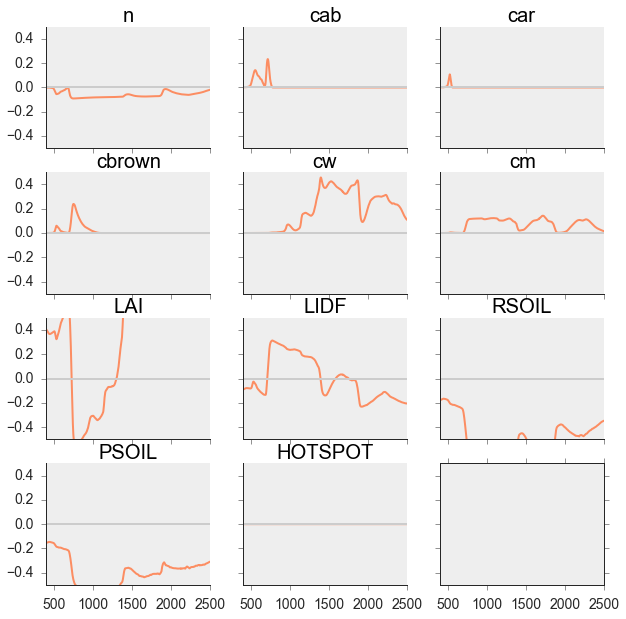

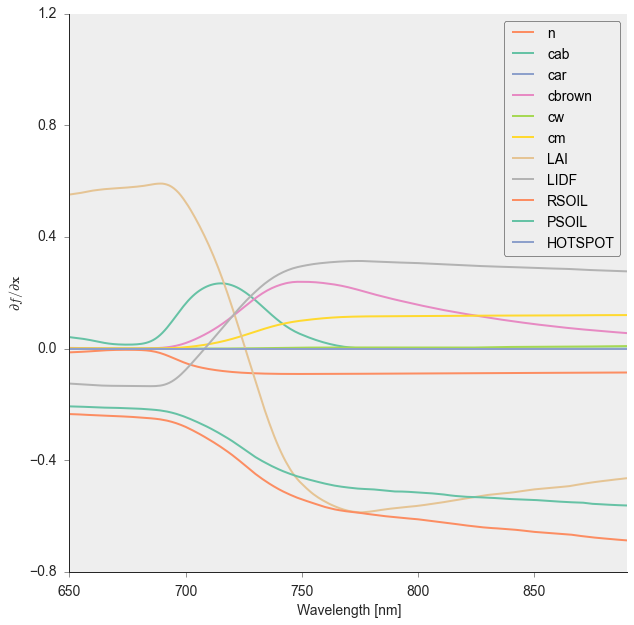

In [4]:
w,s = prosail_sensitivity_ssa(vza=0, sza=0)
plt.xlim ( 650, 890)

### A trip to RED/NIR space

Perhaps the first thing you've heard about optical remote sensing is about the use of $NDVI$, the normalised difference vegetation index. This index has a long history in remote sensing, and one could say that it is broadly related to the amount of green vegetation. $NDVI$ is calculated using the red and NIR bands (typically, wavelenghts around 680 and 865 nm):

$$
NDVI=\frac{NIR-RED}{NIR+RED}.
$$
As it is a normalised quantity, NDVI goes between -1 and 1, but for vegetation, we usually find that it goes from $\sim$ 0.2 to 0.9.

* $NDVI$ has been correlated to most things. Based on the sensitivity analysis you performed above, can you suggest some of these correlates?

* $NDVI* is often used as a proxy for LAI. You can use the provided function to explore the relationship beween the VI and LAI. What are your observations?
* You can set a number of extra *nuisance* parameters to vary randomly. Discuss how the value of these different parameters affects the value of the calculated NDVI, and how it affects your retrieval of e.g. LAI. Relate this to your sensitivity analysis.
* You can also change the soil brightness term. What do you observe? Can you explain the physics that give rise to what you observe?
* Consider the SAVI index. What is the role of $L$?






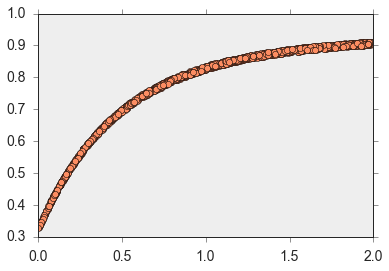

In [100]:
x0=np.array([1.5, 40., 5., 0., 0.0113, 0.0053, 1,  30., 2, 0, 0.01])
minvals = {'n':1.0, 'cab':15., 'car':10., 'cbrown': 0., 'cw':0.001, 'cm':0.0, 
                               'lai':.5, 'lidf':0., 'rsoil':0., 'psoil':0., 'hspot':0.0001 }
maxvals = { 'n': 2.5, 'cab': 80., 'car':20., 'cbrown': .1, 'cw':0.04, 'cm': 0.5,
                               'lai':8.05, 'lidf':90., 'rsoil':2., 'psoil':2., 'hspot':0.5 }
sza=0.
vza=30.
raa=10.
n_tries = 1500
param_names = ['n','cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'lidf', 'rsoil', 'psoil', 'hspot']
        
nuisance = ['lai']
wv = np.arange( 400, 2501 )
red_pass = (wv == 650 )
nir_pass = ( wv == 865 )

xbase = np.zeros ( 11 )
span  = np.zeros ( 11 )
for i, param in enumerate ( param_names ):
    xbase[i] = minvals[param]
    if param in nuisance:
        span[i] = (maxvals[param] - minvals[param])

x = []
red = []
nir = []
for n_tries in xrange(n_tries):
    xp = x0*1.
    xp[6] = np.random.rand()*2 + 0.
    xp[1] = np.random.rand()*10 + 40.
    r = call_prosail ( *(xp.tolist() + [sza, vza,raa]) )
    red.append ( r[red_pass].sum() )
    nir.append(r[nir_pass].sum() )
    x.append ( xp )
x = np.array ( x )
red = np.array ( red )
nir = np.array ( nir )

ndvi = (nir - red)/(nir+red)

plt.plot ( x[:, 6], ndvi, 'o')
plt.figure()


(0.2, 1.2)

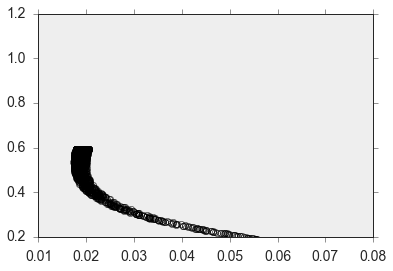

In [99]:
plt.plot ( red, nir, 'o', markeredgecolor="k", markerfacecolor="none")
plt.plot ( red[x[:,6]<0.2],nir[x[:,6]<0.2], 'o',markeredgecolor="r", markerfacecolor="none")
plt.ylim(0.2, 1.2)

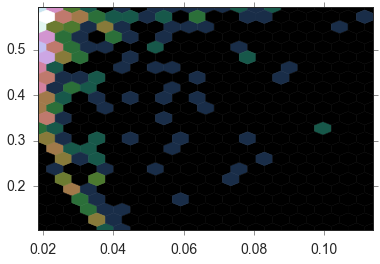

In [35]:
plt.hexbin(red, nir, gridsize=20, bins="log")

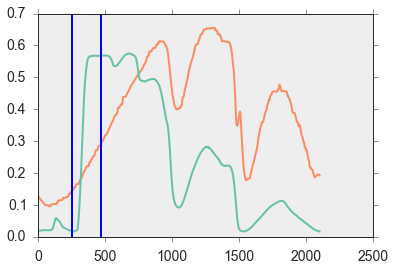

In [88]:
xp[6] = 0.01
xp[8] = 4
xp[9] = 0
r=call_prosail ( *(xp.tolist() + [sza, vza,raa]) )
plt.plot(r)

xp[6] = 5
xp[8] = 4
xp[9] = 0.
r=call_prosail ( *(xp.tolist() + [sza, vza,raa]) )
plt.plot(r)
plt.axvline ( 650-400 )
plt.axvline ( 865-400 )

### Exploring the MTCI (MERIS Terrestrial Chlorophyll Index)

The MTCI is a vegetation index that was developed for data from the MERIS sensor onboard the ENVISAT platform, and that relates surface reflectance to canopy chlorophyll content. The index is defined as the ratio of reflectance differences between MERIS bands 10 and 9 to reflectance differences between bands 9 and 8. 

$$
MTCI = \frac{R_{753}-R_{705}}{R_{705}-R_{681}},
$$
where $R_{x}$ indicated reflectance for a waveband whose centre wavelength is located at $x$. In this experiment, we will use PROSAIL to look at the robustness of such an index. We note that the bandwidth of these three bands is 7.5, 10 and 7.5 $nm$.

* A first experiment will be to determine the strength of the relationship just sweeping over the chlorophyll concentration while keeping all other parameters fixed. Try different regions of parameters space (e.g. set ``x0`` to some other value).
* As a second experiment, add some *nuisance parameters*: e.g. add a random variation variation to other parameters other than $C_{ab}$. The variation in this parameters is controlled by the ``minvals`` and ``maxvals`` dictionaries. Comment on the results, and in particular, in the robustness of the regression.
* A third experiment will also add some noise using the ``noise_level`` parameters. We can assume that ``noise_level`` is the standard deviation of some additive Gaussian noise. Values of 0.01 are probably optimistic for the type of atmospheric correction we typically get.
* Finally, observe the changes in the $MTCI-C_{ab}$ relationship for different acquisition geometries.




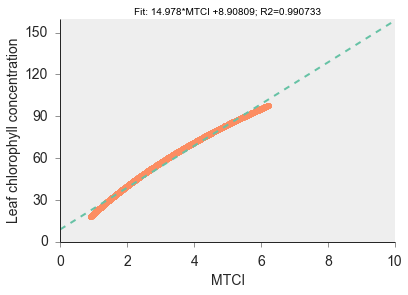

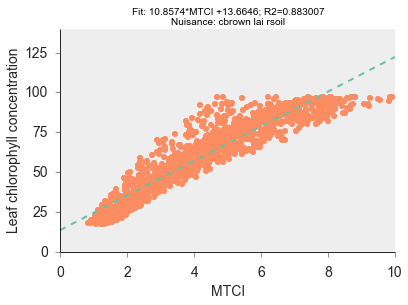

In [3]:
x, y, p0, p1 = mtci_experiment( )
plt.figure()
x, y, p0, p1 = mtci_experiment( nuisance=["cbrown", "lai", "rsoil"], vza=70.)



1. Explore VIS/NIR space and NDVI
2. Red edge?